In [22]:
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import statistics
from scipy import stats
import scipy
import networkx as nx
import random
from statistics import mean
import seaborn as sns

In [2]:
DFAllFirms = pd.read_csv(
    "/Users/SatouDaisuke/Documents/gsais/dataAnalysis/data/KJDATA1.TXT",
    encoding='cp932')
DFAllKyotoFirms = pd.read_excel(
    "/Users/SatouDaisuke/Documents/gsais/dataAnalysis/data/KJDATA_allKyotoCompanies.xlsx",
    sheet_name="original")
# DFAllTrade = pd.read_csv(
#     "/Users/SatouDaisuke/Documents/gsais/dataAnalysis/data/SKDATA.TXT")
DFTreeAllKyotofirms = pd.read_csv("../py/data/allKyotoFirms.tree")
modifiedDFAllTrade = pd.read_csv("../py/data/modifiedSKDATA.csv")

In [3]:
def bowtie_analysis(G):
    """
    to separate given graph with scc in out tube tendrils other
    """
    scc = max(nx.strongly_connected_components(G), key=len)
    scc = set(scc)
    nodes = set(G.nodes())
    scc_node = random.sample(scc, 1)[0]
    sp = dict(nx.all_pairs_shortest_path_length(G))
    inc = set()
    for n in nodes:
        if scc_node in sp[n]:
            inc.add(n)
    inc -= scc

    outc = set()
    for n in scc:
        outc |= set(sp[n].keys())
    outc -= scc

    tube = set()
    out_tendril = set()
    in_tendril = set()
    other = set()

    remainder = set(G.nodes()) - scc - inc - outc
    inc_out = set()
    for n in inc:
        inc_out |= set(sp[n].keys())
    inc_out = inc_out - inc - scc - outc

    for n in remainder:
        if n in inc_out:
            if set(sp[n].keys()) & outc:
                tube.add(n)
            else:
                in_tendril.add(n)
        elif set(sp[n].keys()) & outc:
            out_tendril.add(n)
        else:
            other.add(n)

    print("SCCの大きさは", len(scc))
    print("INの大きさは", len(inc))
    print("OUTの大きさは", len(outc))
    print("TUBEの大きさは", len(tube))
    print("IN_TENDRILSの大きさは", len(in_tendril))
    print("OUT_TENDRILSの大きさは", len(out_tendril))
    print("OTHERの大きさは", len(other))

    return scc, inc, outc, tube, in_tendril, out_tendril, other

In [5]:
def make_tradedata(firms):
    """
    企業データを持ったdfを元に、dfに存在する全ての企業が関係する取引を返すメソッド

    args: firms DF

    return DF => 取引関係を持つ企業を返す
    """
    a = modifiedDFAllTrade[modifiedDFAllTrade["supplier"].isin(firms["企業コード"])]
    b = modifiedDFAllTrade[modifiedDFAllTrade["customer"].isin(firms["企業コード"])]

    c = pd.concat([a, b])

    d = c[~c.duplicated()]

    print("取引の数は", len(d))

    return d[["supplier", "customer"]]

In [7]:
def make_tuple_from_df(df):
    """
    dataframeの行からtupleを生み出す
    """
    tuples = [tuple(x) for x in df.values]
    print(len(tuples))
    return tuples

In [9]:
def culclulate_graph_feature(G):
    print("平均最短経路長は", nx.average_shortest_path_length(G))
    print("クラスタリング係数は", nx.average_clustering(G))
    print("assortativityは", nx.degree_assortativity_coefficient(G))
    print("densityは", nx.density(G))

In [13]:
def get_graph(module):
    infofirms = get_companyInfo_from_module(module)
    tradedata = make_tradedata_for_community(infofirms)
    links = [tuple(x) for x in tradedata.values]

    D = nx.DiGraph()
    D.add_edges_from(links)
    print("ノードの数=", D.number_of_nodes(), "\n リンクの数=", D.number_of_edges())

    return D

In [14]:
def get_companyInfo_from_module(module):
    cols = DFAllKyotoFirms.columns
    infofirms = pd.DataFrame(index=[], columns=cols)

    df = DFTreeAllKyotofirms[DFTreeAllKyotofirms["module"].str.startswith(
        module)]
    print("{}moduleの長さは{}".format(module, len(df)))

    for code in df["company_code"]:
        info = find_company_in_all(code)
        infofirms = infofirms.append(info)

    return infofirms

In [15]:
def make_tradedata_for_community(infofirms):
    """
    企業データを持ったdfを元に、dfに存在する全ての企業同士の取引を返すメソッド

    args: infofirms DF

    return DF => 取引関係を持つ企業を返す
    """
    tradeData = modifiedDFAllTrade[modifiedDFAllTrade["supplier"].isin(
        infofirms["企業コード"]) & modifiedDFAllTrade["customer"].isin(infofirms["企業コード"])]

    # ノードたちをエクセル表に出力
    firms = list(
        set(list(tradeData["supplier"]) + list(tradeData["customer"])))
    print("node数: {}".format(len(firms)))
    print("抽出した取引の数: {}".format(len(tradeData)))

    print("取引データの中で重複しているデータの数は(True=重複): {}".format(
        dict(tradeData.duplicated().value_counts())))

    return tradeData[["supplier", "customer"]]

In [17]:
def find_company_in_all(company_code):
    df = DFAllFirms[DFAllFirms["企業コード"] == company_code]
    return df

In [8]:
tradeData = make_tradedata(DFAllKyotoFirms)
links = make_tuple_from_df(tradeData)
kG = nx.DiGraph()
kG.add_edges_from(links)
kscc, kinc, koutc, ktube, kin_tendril, kout_tendril, kother = bowtie_analysis(kG)

取引の数は 153684
153684
SCCの大きさは 13206
INの大きさは 23643
OUTの大きさは 30950
TUBEの大きさは 290
IN_TENDRILSの大きさは 2705
OUT_TENDRILSの大きさは 5105
OTHERの大きさは 3779


In [18]:
print("========================\n")
print("任天堂のコミュニティの特徴")
D_14_1 = get_graph("14:1:")
culclulate_graph_feature(D_14_1)

print("========================\n")
print("日本電産のコミュニティの特徴")
D_2_18 = get_graph("2:18:")
culclulate_graph_feature(D_2_18)


print("========================\n")
print("西陣織のコミュニティの特徴")
D_4_1 = get_graph("4:1:")
culclulate_graph_feature(D_4_1)


print("========================\n")
print("京友禅のコミュニティの特徴")
D_4_6 = get_graph("4:6:")
culclulate_graph_feature(D_4_6)


print("========================\n")
print("京人形のコミュニティの特徴")
D_4_25 = get_graph("4:25:")
culclulate_graph_feature(D_4_25)

print("========================\n")
print("堀場製作所のコミュニティの特徴")
D_2_9 = get_graph("2:9:")
culclulate_graph_feature(D_2_9)

print("========================\n")
print("村田製作所のコミュニティの特徴")
D_2_4 = get_graph("2:4:")
culclulate_graph_feature(D_2_4)

print("========================\n")
print("京都府を中心とする建築のコミュニティの特徴")
D_1_1 = get_graph("1:1:")
culclulate_graph_feature(D_1_1)

print("========================\n")
print("京都府を中心とする建築のコミュニティの特徴")
D_1_115 = get_graph("1:115:")
culclulate_graph_feature(D_1_115)


任天堂のコミュニティの特徴
14:1:moduleの長さは212


//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


node数: 212
抽出した取引の数: 325
取引データの中で重複しているデータの数は(True=重複): {False: 325}
ノードの数= 212 
 リンクの数= 308
平均最短経路長は 0.5638021997675042
クラスタリング係数は 0.19064291443673154
assortativityは -0.5789546170623502
densityは 0.006885451131181258

日本電産のコミュニティの特徴
2:18:moduleの長さは132
node数: 132
抽出した取引の数: 150
取引データの中で重複しているデータの数は(True=重複): {False: 150}
ノードの数= 132 
 リンクの数= 146
平均最短経路長は 0.30407124681933845
クラスタリング係数は 0.06755749547641772
assortativityは -0.6769622529961249
densityは 0.00844321073328707

西陣織のコミュニティの特徴
4:1:moduleの長さは174
node数: 174
抽出した取引の数: 416
取引データの中で重複しているデータの数は(True=重複): {False: 416}
ノードの数= 174 
 リンクの数= 390
平均最短経路長は 0.25200983323367215
クラスタリング係数は 0.006912732673381761
assortativityは -0.36881705303438495
densityは 0.01295594977077935

京友禅のコミュニティの特徴
4:6:moduleの長さは94
node数: 94
抽出した取引の数: 186
取引データの中で重複しているデータの数は(True=重複): {False: 186}
ノードの数= 94 
 リンクの数= 185
平均最短経路長は 1.3331045527339282
クラスタリング係数は 0.06073162235589175
assortativityは -0.5925931870600967
densityは 0.021162205444978266

京人形のコミュニティの特徴
4:25:moduleの長さは71

In [19]:
scc4_1, inc4_1, outc4_1, tube4_1, in_tendril4_1, out_tendril4_1, other4_1 = bowtie_analysis(
    D_4_1)
scc4_6, inc4_6, outc4_6, tube4_6, in_tendril4_6, out_tendril4_6, other4_6 = bowtie_analysis(
    D_4_6)
scc4_25, inc4_25, outc4_25, tube4_25, in_tendril4_25, out_tendril4_25, other4_25 = bowtie_analysis(
    D_4_25)
scc2_18, inc2_18, outc2_18, tube2_18, in_tendril2_18, out_tendril2_18, other2_18 = bowtie_analysis(
    D_2_18)
scc14_1, inc14_1, outc14_1, tube14_1, in_tendril14_1, out_tendril14_1, other14_1 = bowtie_analysis(
    D_14_1)
scc1_115, inc1_115, outc1_115, tube1_115, in_tendril1_115, out_tendril1_115, other1_115 = bowtie_analysis(
    D_1_115)

SCCの大きさは 2
INの大きさは 7
OUTの大きさは 46
TUBEの大きさは 31
IN_TENDRILSの大きさは 14
OUT_TENDRILSの大きさは 63
OTHERの大きさは 11
SCCの大きさは 33
INの大きさは 20
OUTの大きさは 41
TUBEの大きさは 0
IN_TENDRILSの大きさは 0
OUT_TENDRILSの大きさは 0
OTHERの大きさは 0
SCCの大きさは 2
INの大きさは 11
OUTの大きさは 15
TUBEの大きさは 19
IN_TENDRILSの大きさは 20
OUT_TENDRILSの大きさは 3
OTHERの大きさは 1
SCCの大きさは 5
INの大きさは 111
OUTの大きさは 16
TUBEの大きさは 0
IN_TENDRILSの大きさは 0
OUT_TENDRILSの大きさは 0
OTHERの大きさは 0
SCCの大きさは 25
INの大きさは 135
OUTの大きさは 52
TUBEの大きさは 0
IN_TENDRILSの大きさは 0
OUT_TENDRILSの大きさは 0
OTHERの大きさは 0
SCCの大きさは 11
INの大きさは 27
OUTの大きさは 20
TUBEの大きさは 0
IN_TENDRILSの大きさは 1
OUT_TENDRILSの大きさは 1
OTHERの大きさは 0


In [144]:
bowtie_element = ["SCC", "IN", "OUT", "IN_TE", "OUT_TE", "TUBE", "OTHER"]
w = [kscc, kinc, koutc, ktube, kin_tendril, kout_tendril, kother]
industries = ["Nishijin", "Yuzen", "Ningyo", "Game", "Machine", "Civil"]
p4_1 = [scc4_1, inc4_1, outc4_1, in_tendril4_1, out_tendril4_1, tube4_1, other4_1]
p4_6= [scc4_6, inc4_6, outc4_6, tube4_6, in_tendril4_6, out_tendril4_6, other4_6]
p4_25 = [scc4_25, inc4_25, outc4_25, tube4_25, in_tendril4_25, out_tendril4_25, other4_25]
p14_1 = [scc14_1, inc14_1, outc14_1, tube14_1, in_tendril14_1, out_tendril14_1, other14_1]
p2_18 = [scc2_18, inc2_18, outc2_18, tube2_18, in_tendril2_18, out_tendril2_18, other2_18]
p1_115 = [scc1_115, inc1_115, outc1_115, tube1_115, in_tendril1_115, out_tendril1_115, other1_115]
p = [p4_1, p4_6, p4_25, p14_1, p2_18, p1_115]

In [159]:
bowtie_df = pd.DataFrame(columns=bowtie_element, index=bowtie_element, dtype=int)

for i, bf in enumerate(w):
    for j, sf in enumerate(p4_1):
        print(sf)
        bowtie_df.at[bowtie_element[j], bowtie_element[i]] = len(w[i] & p4_1[j]) if len(w[i] & p4_1[j]) != 0 else 0

{870408356, 641125500}
{640017410, 642149860, 580004651, 642114129, 641162545, 641089686, 570564220}
{641164548, 641416458, 10168079, 641312784, 570585104, 641403410, 293138710, 291093531, 400706598, 291379516, 510056768, 291706436, 641126212, 291418953, 401146189, 641082959, 641299028, 642005850, 641366108, 570279780, 140404082, 641417845, 760036730, 16918142, 291121535, 642299781, 291005063, 575476362, 641080727, 641383835, 641085354, 870210734, 291074499, 12266949, 20016840, 641119178, 641119186, 570022614, 291337945, 641142234, 270256091, 470170603, 641430256, 60002034, 650038002, 294111735}
{297894498, 270158626, 641194978, 641121962, 13729322, 642218250, 641372205, 642158509, 641142420, 641403640, 220129274, 292375484, 910075646, 402369343}
{641413122, 641141254, 641299591, 642163723, 642375437, 641093519, 641097875, 641125526, 641115415, 641312792, 641149719, 641228058, 641371675, 641080735, 641186207, 641120290, 641089570, 641416873, 641353898, 641171757, 641169710, 641299761, 

In [177]:
def make_heatmap(df, title):
    ax = plt.axes()
    sns.heatmap(df,annot=True, cmap='Blues')

    ax.set_title("The number of firms for {}".format(title))
    ax.set_xlabel("Whole Kyoto Network")
    ax.set_ylabel("Community Network")

Text(32.09375, 0.5, 'Community Network')

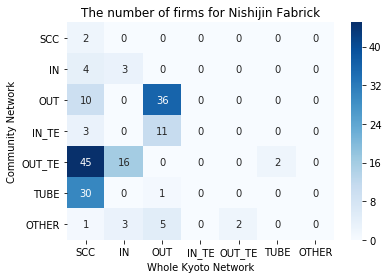

In [176]:
ax = plt.axes()
sns.heatmap(bowtie_df4_1,annot=True, cmap='Blues')

ax.set_title("The number of firms for Nishijin Fabrick")
ax.set_xlabel("Whole Kyoto Network")
ax.set_ylabel("Community Network")

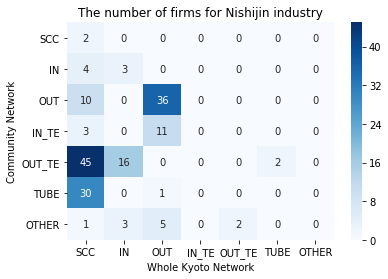

In [178]:
make_heatmap(bowtie_df4_1, "Nishijin fabrick")

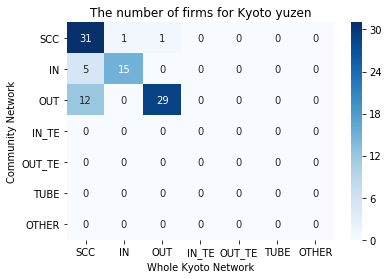

In [179]:
make_heatmap(bowtie_df4_6, "Kyoto yuzen")

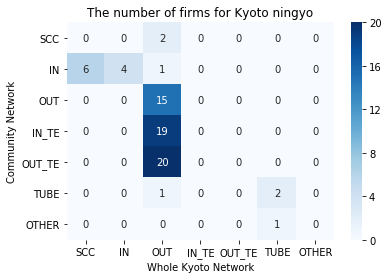

In [180]:
make_heatmap(bowtie_df4_25, "Kyoto ningyo")

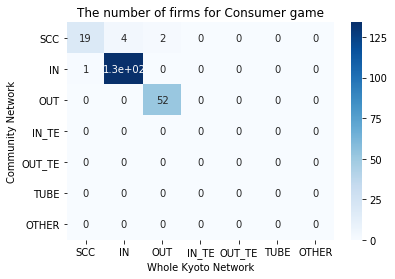

In [181]:
make_heatmap(bowtie_df14_1, "Consumer game")

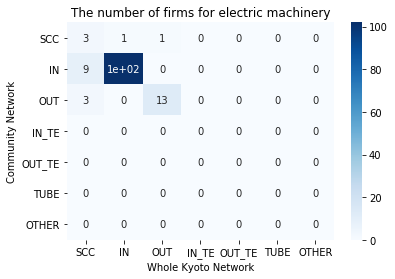

In [182]:
make_heatmap(bowtie_df2_18, "electric machinery")

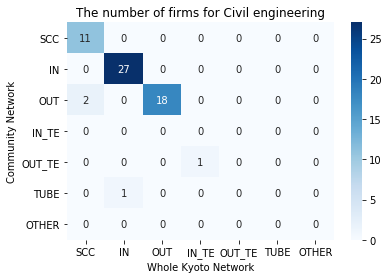

In [183]:
make_heatmap(bowtie_df1_115, "Civil engineering")

In [174]:
bowtie_df4_1 = pd.DataFrame(columns=bowtie_element, index=bowtie_element, dtype=int)
bowtie_df4_6 = pd.DataFrame(columns=bowtie_element, index=bowtie_element, dtype=int)
bowtie_df4_25 = pd.DataFrame(columns=bowtie_element, index=bowtie_element, dtype=int)
bowtie_df14_1 = pd.DataFrame(columns=bowtie_element, index=bowtie_element, dtype=int)
bowtie_df2_18 = pd.DataFrame(columns=bowtie_element, index=bowtie_element, dtype=int)
bowtie_df1_115 = pd.DataFrame(columns=bowtie_element, index=bowtie_element, dtype=int)

bundle_df = [bowtie_df4_1, bowtie_df4_6,bowtie_df4_25, bowtie_df14_1, bowtie_df2_18 ,bowtie_df1_115]

for index, bdf in enumerate(bundle_df):
    for i, bf in enumerate(w):
            for j, e in enumerate(p[index]):
                bdf.at[bowtie_element[j], bowtie_element[i]] = len(w[i] & p[index][j]) if len(w[i] & p[index][j]) != 0 else 0

In [173]:
bowtie_df4_25

,SCC,IN,OUT,IN_TE,OUT_TE,TUBE,OTHER
SCC,0.0,0.0,2.0,0.0,0.0,0.0,0.0
IN,6.0,4.0,1.0,0.0,0.0,0.0,0.0
OUT,0.0,0.0,15.0,0.0,0.0,0.0,0.0
IN_TE,0.0,0.0,19.0,0.0,0.0,0.0,0.0
OUT_TE,0.0,0.0,20.0,0.0,0.0,0.0,0.0
TUBE,0.0,0.0,1.0,0.0,0.0,2.0,0.0
OTHER,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Text(32.09375, 0.5, 'Community Network')

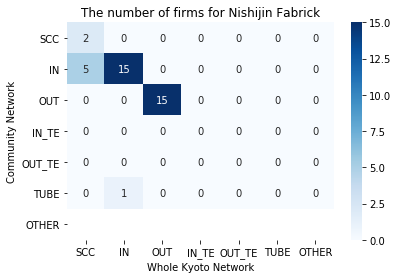

In [152]:
ax = plt.axes()
sns.heatmap(bowtie_df4_1,annot=True, cmap='Blues')

ax.set_title("The number of firms for Nishijin Fabrick")
ax.set_xlabel("Whole Kyoto Network")
ax.set_ylabel("Community Network")

In [70]:
for i, bf in enumerate(w):
    for j, sf in enumerate(p):
        firms = w[i] & p[j]
        np_array = np.empty((0, 3))
        for index, f in enumerate(firms):
            firminfo = find_company_in_all(f)
            sales = int(firminfo["前期決算＿売上高（千円）"].values[0].replace(
                " ", "")) if firminfo["前期決算＿売上高（千円）"].values[0].replace(" ", "") != '' else np.nan
            profit = int(firminfo["前期決算＿利益金（千円）"].values[0].replace(
                " ", "")) if firminfo["前期決算＿利益金（千円）"].values[0].replace(" ", "") != '' else np.nan
            employee = int(firminfo["従業員数"].values[0].replace(
                " ", "")) if firminfo["従業員数"].values[0].replace(" ", "") != '' else np.nan
            np_array = np.append(np_array, np.array([[sales, profit, employee]]), axis=0)

        # print(np_array[~np.isnan(np_array).any(axis=1),:])
        bowtie_df.at[bowtie_element[j], bowtie_element[i]] = len(
            np_array[~np.isnan(np_array).any(axis=1),:])
        # bowtie_df.at[bowtie_element[j], bowtie_element[i]] = len(
        #     np_array[~np.isnan(np_array[:,1]),:])

In [79]:
df = pd.DataFrame(columns=bowtie_element, index=bowtie_element)

for i, bf in enumerate(w):
    for j, sf in enumerate(p):
        firms = w[i] & p[j]
        np_array = np.empty((0, 3))
        previous_profit_count = 0
        current_profit_count = 0
        both_profit_count = 0
        for index, f in enumerate(firms):
            firminfo = find_company_in_all(f)
            # 必要な数値は前期売り上げがある。当期売り上げがある。前当期ともにある
            if firminfo["前期決算＿利益金（千円）"].values[0].replace(" ", "") != '' and  firminfo["当期決算＿利益金（千円）"].values[0].replace(" ", "") != '':
                both_profit_count += 1
            elif firminfo["前期決算＿利益金（千円）"].values[0].replace(" ", "") != '':
                previous_profit_count += 1
            elif firminfo["当期決算＿利益金（千円）"].values[0].replace(" ", "") != '':
                 current_profit_count += 1
            sumprofit = both_profit_count + previous_profit_count + current_profit_count
            
            df.at[bowtie_element[j], bowtie_element[i]] = "企業数{}, 両方{}, 前期だけ{}, 当期だけ{}, 利益データの存在する割合は{}%".format(len(w[i] & p[j]), both_profit_count, previous_profit_count,current_profit_count, (sumprofit / len(w[i] & p[j]) * 100)) if len(w[i] & p[j]) != 0 else "fuck"

In [80]:
display(df)

,SCC,IN,OUT,IN_TE,OUT_TE,TUBE,OTHER
SCC,"企業数2, 両方1, 前期だけ0, 当期だけ1, 利益の存在する割合は100.0%",NaN,NaN,NaN,NaN,NaN,NaN
IN,"企業数4, 両方1, 前期だけ0, 当期だけ0, 利益の存在する割合は25.0%","企業数3, 両方1, 前期だけ0, 当期だけ0, 利益の存在する割合は33.33333333...",NaN,NaN,NaN,NaN,NaN
OUT,"企業数10, 両方2, 前期だけ0, 当期だけ1, 利益の存在する割合は30.0%",NaN,"企業数36, 両方14, 前期だけ2, 当期だけ3, 利益の存在する割合は52.777777...",NaN,NaN,NaN,NaN
IN_TE,"企業数3, 両方0, 前期だけ0, 当期だけ1, 利益の存在する割合は33.33333333...",NaN,"企業数11, 両方0, 前期だけ0, 当期だけ1, 利益の存在する割合は9.09090909...",NaN,NaN,NaN,NaN
OUT_TE,"企業数45, 両方2, 前期だけ1, 当期だけ0, 利益の存在する割合は6.66666666...","企業数16, 両方3, 前期だけ0, 当期だけ0, 利益の存在する割合は18.75%",NaN,NaN,NaN,"企業数2, 両方0, 前期だけ0, 当期だけ0, 利益の存在する割合は0.0%",NaN
TUBE,"企業数30, 両方3, 前期だけ1, 当期だけ1, 利益の存在する割合は16.6666666...",NaN,"企業数1, 両方0, 前期だけ0, 当期だけ0, 利益の存在する割合は0.0%",NaN,NaN,NaN,NaN
OTHER,"企業数1, 両方0, 前期だけ0, 当期だけ1, 利益の存在する割合は100.0%","企業数3, 両方0, 前期だけ1, 当期だけ0, 利益の存在する割合は33.33333333...","企業数5, 両方2, 前期だけ0, 当期だけ0, 利益の存在する割合は40.0%",NaN,"企業数2, 両方1, 前期だけ1, 当期だけ0, 利益の存在する割合は100.0%",NaN,NaN


In [92]:
profitabilityDf = pd.DataFrame(columns=bowtie_element, index=bowtie_element, dtype=int)
productivityDf = pd.DataFrame(columns=bowtie_element, index=bowtie_element, dtype=int)

for i, bf in enumerate(w):
    for j, sf in enumerate(p):
        firms = w[i] & p[j]
        previous_data = np.empty((0, 3))
        current_data = np.empty((0, 3))
        for index, f in enumerate(firms):
            firminfo = find_company_in_all(f)
            previous_sales = int(firminfo["前期決算＿売上高（千円）"].values[0].replace(
                " ", "")) if firminfo["前期決算＿売上高（千円）"].values[0].replace(" ", "") != '' else np.nan
            previous_profit = int(firminfo["前期決算＿利益金（千円）"].values[0].replace(
                " ", "")) if firminfo["前期決算＿利益金（千円）"].values[0].replace(" ", "") != '' else np.nan
            current_sales = int(firminfo["当期決算＿売上高（千円）"].values[0].replace(
                " ", "")) if firminfo["当期決算＿売上高（千円）"].values[0].replace(" ", "") != '' else np.nan
            current_profit = int(firminfo["当期決算＿利益金（千円）"].values[0].replace(
                " ", "")) if firminfo["当期決算＿利益金（千円）"].values[0].replace(" ", "") != '' else np.nan
            employee = int(firminfo["従業員数"].values[0].replace(
                " ", "")) if firminfo["従業員数"].values[0].replace(" ", "") != '' else np.nan
            previous_data = np.append(previous_data, np.array(
                [[previous_sales, previous_profit, employee]]), axis=0)
            current_data = np.append(current_data, np.array(
                [[current_sales, current_profit, employee]]), axis=0)

        withProfit_previous = previous_data[~np.isnan(previous_data).any(axis=1),:]
        withProfit_current = current_data[~np.isnan(
            current_data).any(axis=1),: ]

        withProfit = np.append(withProfit_previous, withProfit_current, axis=0)

        if len(withProfit) == 0:
            profitabilityDf.at[bowtie_element[j], bowtie_element[i]] = 0
            productivityDf.at[bowtie_element[j], bowtie_element[i]] = 0
        else:
            profitRateSum = 0
            profitabilitySum = 0
            for info in withProfit:
                profitRateSum += (info[1] / info[0] * 100)
                profitabilitySum += (info[1] / info[2])

            profitRate = (profitRateSum / len(withProfit)).round(2)
            profitability = (profitabilitySum / len(withProfit)).round(2)

            profitabilityDf.at[bowtie_element[j], bowtie_element[i]] = profitRate
            productivityDf.at[bowtie_element[j], bowtie_element[i]] = profitability

Text(32.09375, 0.5, 'Community Network')

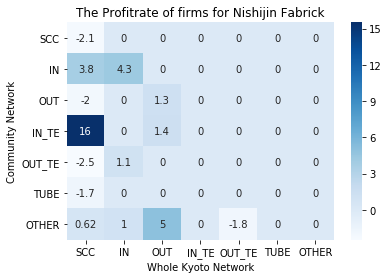

In [93]:
ax = plt.axes()
sns.heatmap(profitabilityDf,annot=True, cmap='Blues')

ax.set_title("The Profitrate of firms for Nishijin Fabrick")
ax.set_xlabel("Whole Kyoto Network")
ax.set_ylabel("Community Network")

Text(32.09375, 0.5, 'Community Network')

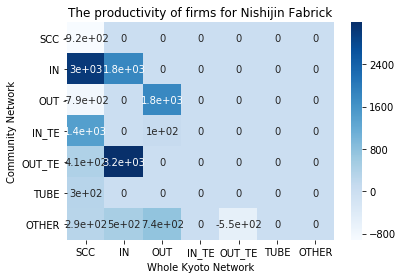

In [94]:
ax = plt.axes()
sns.heatmap(productivityDf,annot=True, cmap='Blues')

ax.set_title("The productivity of firms for Nishijin Fabrick")
ax.set_xlabel("Whole Kyoto Network")
ax.set_ylabel("Community Network")